# Diffusion probabilistic models - Introduction

#### Author : Philippe Esling (esling@ircam.fr)

This second notebook continues the exploration of _diffusion probabilistic models_ [ [ 1 ] ](#ref1) in our four notebook series.
   1. Score matching and Langevin dynamics.
   2. Diffusion probabilistic models and denoising
   3. Applications to waveforms with WaveGrad
   4. Implicit models to accelerate inference

Here, we quickly recall the basics of _score matching_ [ [ 3 ] ](#ref3) and _Langevin dynamics_ seen in the previous notebook. Then, we introduce the original formulation of diffusion probabilistic models based on thermodynamics [ [ 2 ] ](#ref2), and more recent formulations from _denoising_ [ [ 1 ] ](#ref1).

## Theoretical bases - quick recap

In this section we provide a quick recap on **score matching** from the previous notebook, still based on the _swiss roll_ dataset.

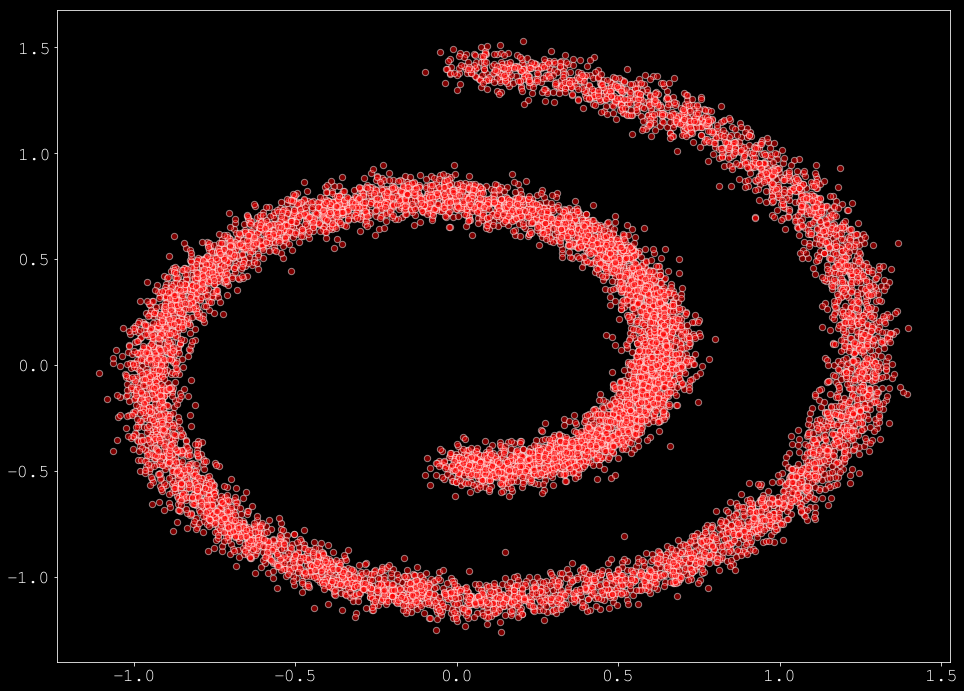

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()
# Sample a batch from the swiss roll
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40);

### Score matching

_Score matching_ aims to learn the _gradients_ (termed _score_) of $\log p(\mathbf{x})$ with respect to $\mathbf{x}$ instead of directly $\log p(\mathbf{x})$. Therefore, we seek a model to approximate
$$
\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})
$$

We have seen that optimizing this model with an MSE objective was equivalent to optimizing

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

where $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ denotes the Jacobian of $\mathcal{F}_{\theta}(\mathbf{x})$ with respect to $\mathbf{x}$. The problem with this formulation lies in the computation of this Jacobian, which does not scale well to high-dimensional data. This leads to a more efficient formulation of _sliced_ score matching, which relies on _random projections_ to approximate the computation of the Jacobian with

$$ E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \mathbf{v}^T \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \mathbf{v} + \frac{1}{2} \left\Vert \mathbf{v}^T \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

where $\mathbf{v} \sim \mathcal{N}(0, 1)$ are a set of Normal-distributed vectors. They show that this can be computed by using forward mode auto-differentiation, which is computationally efficient, as shown in the following implementation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    # Compute the optimized vector-product jacobian
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

#### Denoising score matching

Originally, _denoising score matching_ was discussed by Vincent [ [ 3 ] ](#ref3) in the context of _denoising auto-encoders_. In our case, we can completely remove the use of $\nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})$ in the computation of score matching, by corrupting the inputs through a distribution $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$. It has been shown that the optimal network $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ can be found by minimizing the following objective

$$ E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$

An important remark is that $\mathcal{F}_{\theta}(\mathbf{x}) = \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ is only true when the noise is small enough $q_{\sigma}(\mathbf{x}) \approx p(\mathbf{x})$. As it has been shown in [ [ 3 ] ](#ref3),[ [ 8 ] ](#ref8), if we choose the noise distribution to be $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$, then we have $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$. Therefore, the denoising score matching loss simply becomes

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$

We can implement the _denoising score matching_ loss as follows

In [3]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

Regarding optimization, we can perform a very simple implementation of this process, by define $\mathcal{F}_{\theta}(\mathbf{x})$ as being any type of neural network. We can perform the minimalistic implementation as follows

In [4]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
for t in range(5000):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(9996.8447, grad_fn=<MulBackward0>)
tensor(10036.8750, grad_fn=<MulBackward0>)
tensor(10104.2119, grad_fn=<MulBackward0>)
tensor(9976.1631, grad_fn=<MulBackward0>)
tensor(9974.6611, grad_fn=<MulBackward0>)


We can observe that our model has learned to represent $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$ by plotting the output value across the input space

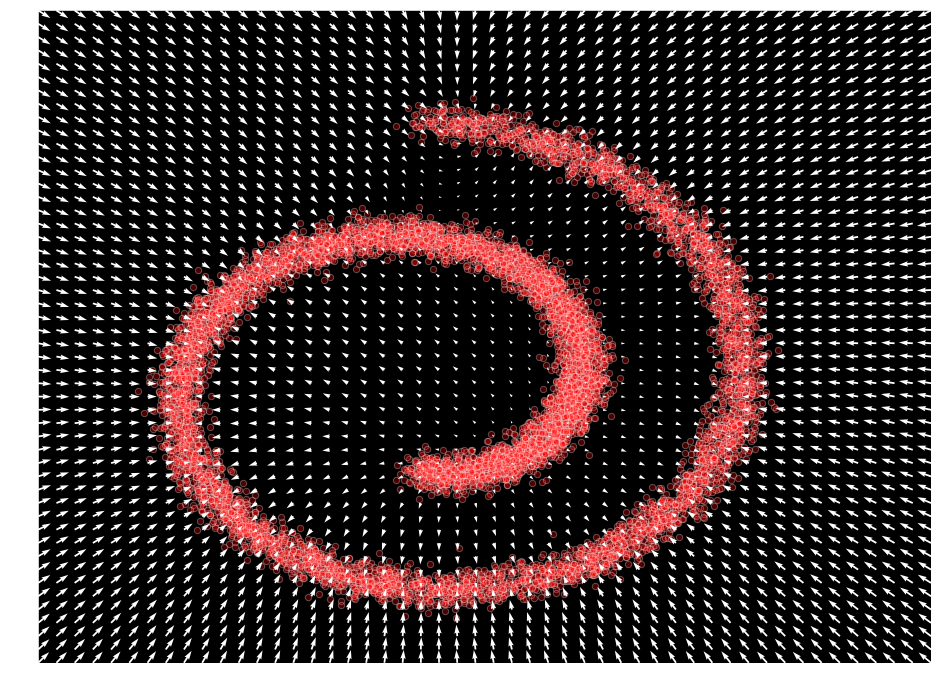

In [5]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.from_numpy(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:,0], scores_log1p[:,1], width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

### Langevin sampling

We have also seen that _Langevin dynamics_ is a process from thermodynamics that can produce true samples from a density $p(\mathbf{x})$, by relying only on $\nabla_{\mathbf{x}} \log p(\mathbf{x})$

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

where $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$ and under $\epsilon \rightarrow 0, t \rightarrow \inf$: $\mathbf{x}_t$ converges to an exact sample from $p(\mathbf{x})$. This is a key idea behind the _score-based generative modeling_ approach.

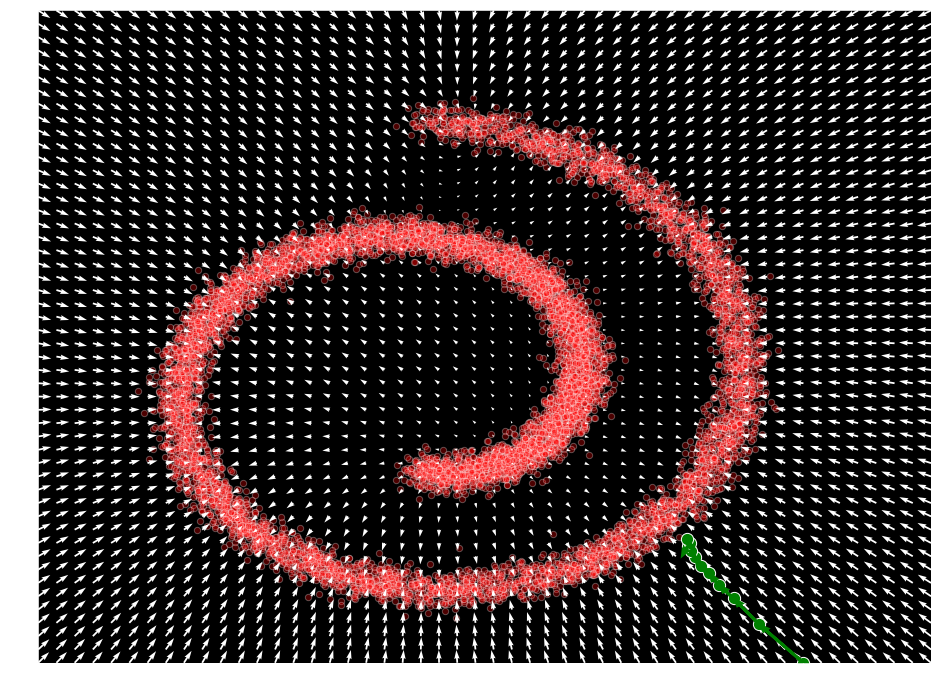

In [6]:
def sample_langevin(model, x, n_steps=10, eps=1e-3, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_langevin(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / torch.tensor(np.linalg.norm(deltas, keepdims=True, axis=-1)) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

## Diffusion models

_Diffusion probabilistic models_ were originally proposed by Sohl-Dickstein et al. [ [ 1 ] ](#ref1) based on non-equilibrium thermodynamics. These models are based on two reciprocal processes that represent two Markov chains of random variables. One process $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ that gradually adds noise to the input data (called the _diffusion_ or _forward_ process), destroying the signal up to full noise. In the opposite direction, the _reverse_ process $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ tries to learn how to invert this diffusion process (transform random noise into a high-quality waveform). This is examplified in the following figure, where we can see the whole model.

<img src="images/diffusion.png" width="100%"/>

As we can see, the _forward_ (and fixed) process $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ gradually introduces noise at each step. Oppositely, the _reverse_ (parametric) process $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ must learn how to _denoise local perturbations_. Hence, learning involves estimating a _large number of small perturbations_, which is more tractable than trying to directly estimate the full distribution with a single potential function. 

Both processes can be defined as parametrized Markov chains, but the _diffusion_ process is usually simplified to inject pre-selected amounts of noise at each step. The _reverse_ process is trained using variational inference, and can be modeled as conditional Gaussians, which allow for neural network parameterization and tractable estimation.

### Formalization

Diffusion models are based on a series of latent variables $ \mathbf{x}_{1},\cdots,\mathbf{x}_{T}$ that have the same dimensionality as a given input data, which is labeled as $\mathbf{x}_{0} \sim q(\mathbf{x}_{0})$. Then, we need to define the behavior of two process

$$
\text{forward (diffusion)} : q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$
$$
\text{reverse (parametric)} : p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

#### Forward process

In the forward process, the data distribution $q(\mathbf{x}_{0})$ is gradually converted into an analytically tractable distribution $\pi(\mathbf{y})$, by repeated application of a Markov diffusion kernel $T_{\pi}(\mathbf{y}\mid\mathbf{y}';\beta)$, with a given diffusion rate $\beta$. 

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = T_{\pi}(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}; \beta_{t})
$$

This diffusion kernel can be set to gradually inject Gaussian noise, given a variance schedule $\beta_{1},\cdots,\beta_{T}$ such that

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

The complete distribution $q(\mathbf{x}_{0:T})$ is called the _diffusion_ process and is defined as

$$
q(\mathbf{x}_{0:T}) =  q(\mathbf{x}_{0}) \prod_{t=1}^{T} q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$

Here, we show how to perform a naive implementation of the simple forward diffusion process with a constant variance schedule

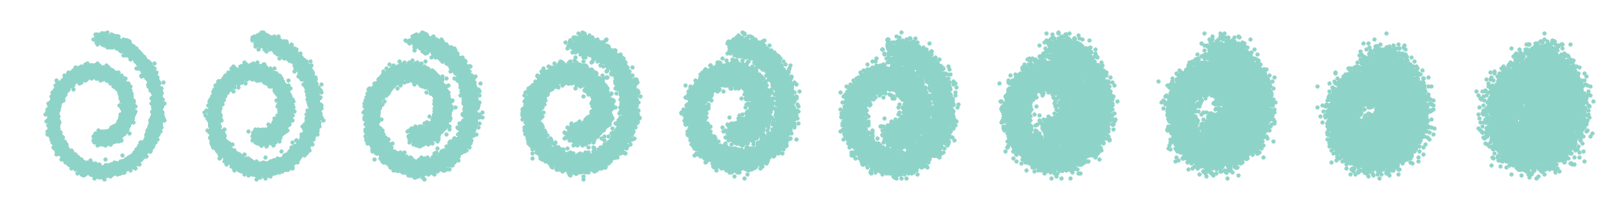

In [7]:
def forward_process(x_start, n_steps, noise=None):
    """ Diffuse the data (t == 0 means diffused for 1 step) """
    x_seq = [x_start]
    for n in range(n_steps):
        x_seq.append((torch.sqrt(1 - betas[n]) * x_seq[-1]) + (betas[n] * torch.rand_like(x_start)))
    return x_seq
n_steps = 100
betas = torch.tensor([0.035] * n_steps)
dataset = torch.Tensor(data.T).float()
x_seq = forward_process(dataset, n_steps, betas)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(x_seq[int((i / 10.0) * n_steps)][:, 0], x_seq[int((i / 10.0) * n_steps)][:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(int((i / 10.0) * n_steps))+'})$')

We can define any type of variance schedules for $\beta_{1},\cdots,\beta_{n}$, as provided in the following function

In [8]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

Interestingly, the forward process admits sampling $\mathbf{x}_{t}$ at an arbitrary timestep $t$. Using notations $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$, we have

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

Therefore, we can update our diffusion sampling function to allow for this mecanism. Note that this depends on the given variance schedule of $\beta_{1},\cdots,\beta_{T}$ that we compute prior to the function.

In [9]:
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

This allows to perform a very efficient implementation of the forward process, where we can directly sample at any given timesteps, as shown in the following code.

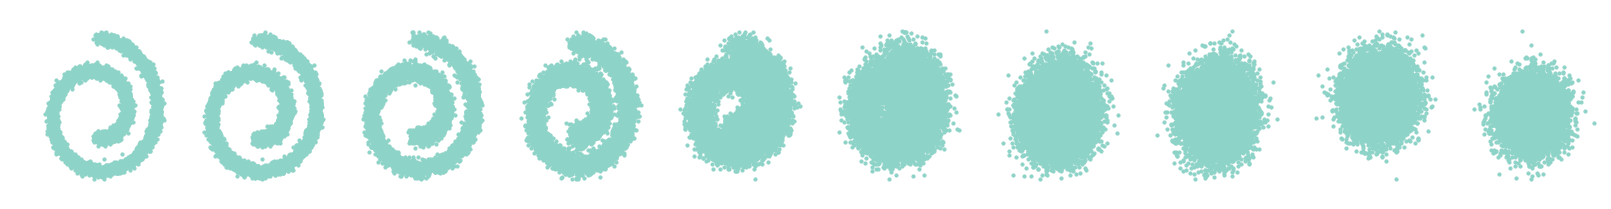

In [10]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_sample(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

Note that for training, we will also need to have access to the mean and variance of the posterior distribution of this process.

In [11]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

#### Reverse process

The generative distribution that we aim to learn will be trained to perform the _reverse_ trajectory, starting from Gaussian noise to gradually remove local perturbations. Therefore the reverse process starts with our given tractable distribution $p(\mathbf{x}_{T})=\pi(\mathbf{x}_{T})$ and is described as

$$
p_{\theta}(\mathbf{x}_{0:T}) =  p(\mathbf{x}_{T}) \prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

Each of the transitions in this process can simply be defined as conditional Gaussians (**note**: which is reminiscent of the definition of VAEs). Therefore, during learning, only the mean and covariancce for a Gaussian diffusion kernel needs to be trained

$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t))
$$

The two functions defining the mean $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ and covariance $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ can be parametrized by deep neural networks. Note also that these functions are parametrized by $t$, which means that a single model can be used for all time steps.

Here, we show a naive implementation of this process, where we have a given `model` to infer variance. Note that this model is _shared across all time steps_ but conditionned on that said time step.

In [12]:
import torch.nn.functional as F
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)
model = ConditionalModel(n_steps)
    
def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

As we can see, the reverse process consists in inferring the values of the mean and log variance for a given timestep. Then, once we have learned the correponding model, we can perform the denoising of any given timestep, by providing both the sample $\mathbf{x}_{t}$ at a given time step, and that time step $t$ that we can use to condition the models for $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ and $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$.

In [13]:
def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    shape = [x.shape[0]] + [1] * (x.ndimension() - 1)
    nonzero_mask = (1 - (t == 0))
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample) 

Finally, obtaining samples from the model is given by running through the whole Markov chain in reverse, starting from the normal distribution to obtain samples from the target distribution. Note that this process can be very slow if we have a large number of steps, as we need to wait for a given $\mathbf{x}_{t}$ to infer the following $\mathbf{x}_{t-1}$

In [14]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

#### Model probability

The complete probability of the generative model is defined as

$$
p_{\theta}(\mathbf{x}_{0}) = \int p_{\theta}(\mathbf{x}_{0:T})d\mathbf{x}_{1:T}
$$

At first sight, this integral appears intractable. However, using a similar approach than variational inference, this integral can be rewritten as

\begin{align}
p_{\theta}(\mathbf{x}_{0}) &= \int p_{\theta}(\mathbf{x}_{0:T})\frac{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})}{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})} d\mathbf{x}_{1:T} \\
&= \int q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0}) \frac{p(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})} d\mathbf{x}_{1:T}
\end{align}


### Training

By using Jensen's inequality on the previous expression, we can see that the training may be performed by optimizing the variational bound on negative log-likelihood

\begin{align}
\mathbb{E}\left[-\log p_{\theta}(\mathbf{x}_{0}) \right] & \leq \mathbb{E}_{q}\left[-\log \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_{0})} \right] \\
\mathcal{L} & = \mathbb{E}_{q}\left[ -\log p(\mathbf{x}_{T}) - \sum_{t\geq 1} \log \frac{p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})}{q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})} \right]
\end{align}

Therefore, efficient training is allowed by optimizing random terms of $\mathcal{L}$ with gradient descent.

To optimize this loss, we will need several computational tools, notably the KL divergence between two gaussians, and the entropy of a Gaussian.

In [15]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

### Training loss

In the original paper by Sohl-Dickstein et al. [ [ 1 ] ](#ref1), this loss is shown to be reducible to

\begin{align}
K = -\mathbb{E}_{q}[ &D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))  \\
&+ H_{q}(\mathbf{X}_{T}\vert\mathbf{X}_{0}) - H_{q}(\mathbf{X}_{1}\vert\mathbf{X}_{0}) - H_{p}(\mathbf{X}_{T})]
\end{align}

Hence, all parts of this loss can be quite easily estimated, as we are dealing with Gaussian distributions in all cases

In [16]:
def compute_loss(true_mean, true_var, model_mean, model_var):
    # the KL divergence between model transition and posterior from data
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float()
    # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
    H_start = entropy(betas[0].float()).float()
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float()
    H_end = entropy(beta_full_trajectory.float()).float()
    H_prior = entropy(torch.tensor([1.])).float()
    negL_bound = KL * n_steps + H_start - H_end + H_prior
    # the negL_bound if this was an isotropic Gaussian model of the data
    negL_gauss = entropy(torch.tensor([1.])).float()
    negL_diff = negL_bound - negL_gauss
    L_diff_bits = negL_diff / np.log(2.)
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

#### Training random time steps

The way that the model is trained is slightly counterintuitive, since we select a timestep at random to train for each of the batch input. The implementation taken from the [DDIM repo](https://github.com/ermongroup/ddim) provides a form of _antithetic sampling_, which allows to ensure that symmetrical points in the different chains are trained jointly. Therefore, the final procedure consists in first run the forward process on each input at a given (random) time steps (performing diffusion). Then we run the reverse process on this sample, and compute the loss.

In [17]:
def loss_likelihood_bound(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the loss
    return compute_loss(true_mean, true_var, model_mean, model_var)

We can very simply optimize this loss with the following training loop.

tensor(134.9538, grad_fn=<MeanBackward0>)
tensor(-2.4417, grad_fn=<MeanBackward0>)
tensor(3.9380, grad_fn=<MeanBackward0>)
tensor(2.4344, grad_fn=<MeanBackward0>)
tensor(1.6676, grad_fn=<MeanBackward0>)
tensor(1.8195, grad_fn=<MeanBackward0>)


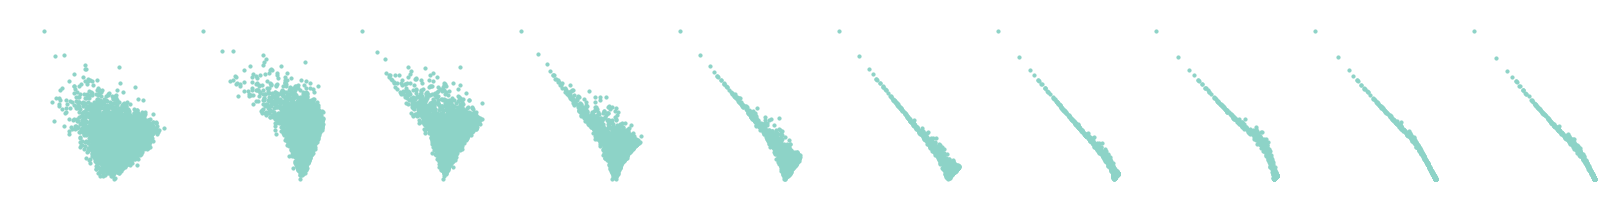

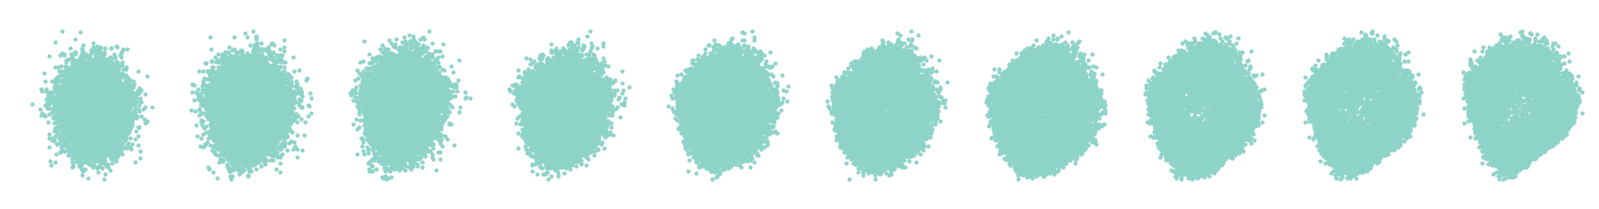

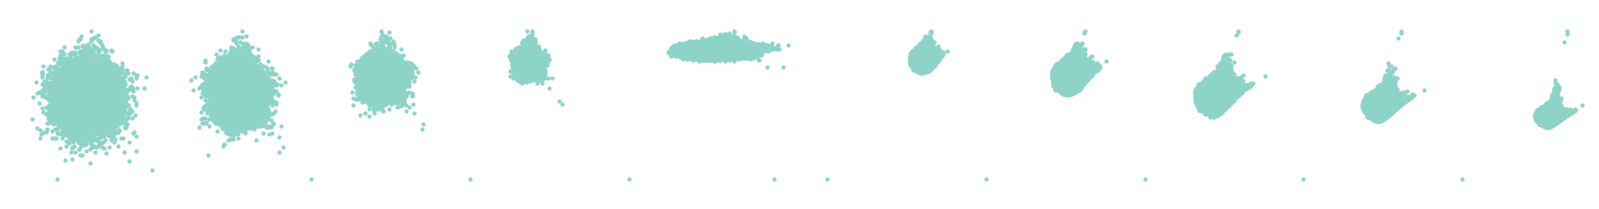

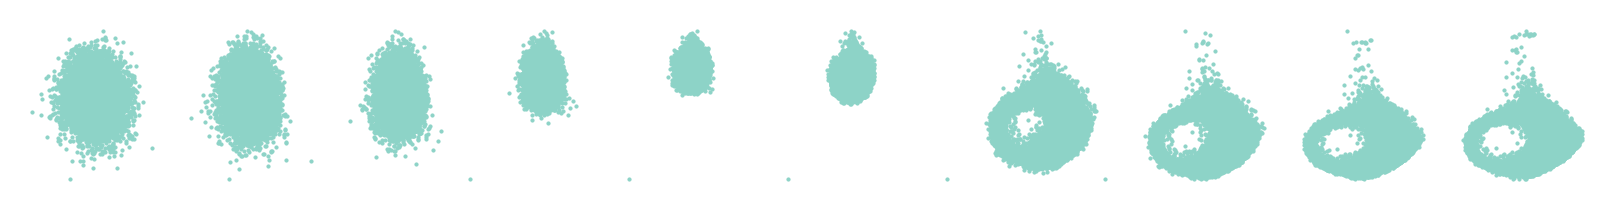

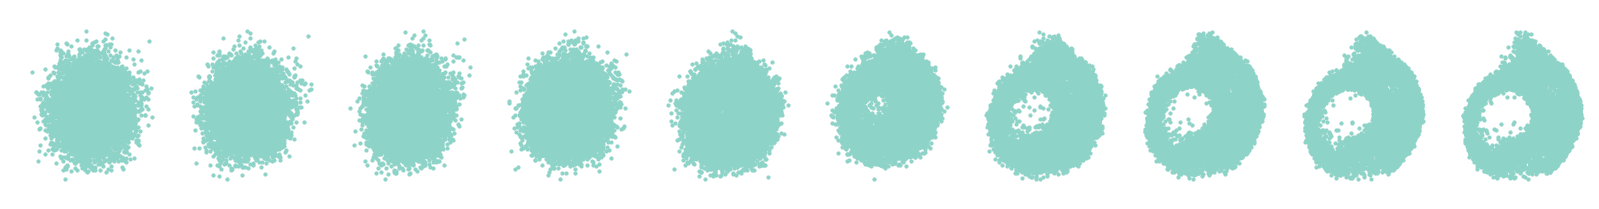

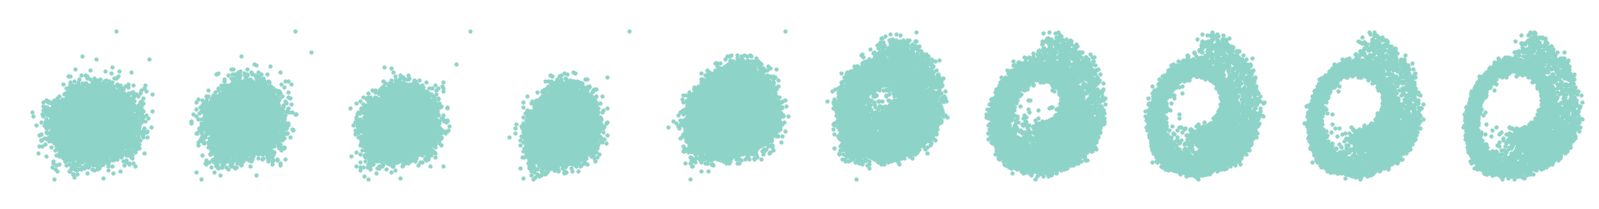

In [18]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
batch_size = 128
for t in range(5001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = loss_likelihood_bound(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
    # Print loss
    if (t % 1000 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## Denoising diffusion probabilistic models (DDPM)

In a very recent article, Ho et al. [ [ 1 ] ](#ref1) constructed over the diffusion models idea, by proposing several enhancements allowing to enhance the quality of the results. First, they proposed to rely on the following parameterization for the mean function
$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

Note that now, the model is trained at outputing directly a form of _noise_ function, which is used in the sampling process. Furthermore, the authors suggest to rather use a fixed variance function

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$

This leads to a new sampling procedure for the reverse process as follows (we also quickly redefine the model to output the correct dimensionality).

In [19]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

Notably, the forward process posteriors are tractable when conditioned on $\mathbf{x}_{0}$

\begin{align}
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) &= \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf {1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
\end{align}

And we can obtain the corresponding mean $\tilde{\mathbf{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0})$ and variance $\tilde{\beta}$ as

\begin{align}
\tilde{\mathbf{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0}) &= \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_{t}}{1 - \bar{\alpha}_{t}}\mathbf{x}_{0} + \frac{\sqrt{\bar{\alpha}_{t}}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t}}\mathbf{x}_{t}\\
\tilde{\beta}_{t} &= \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_{t}}\beta_{t}
\end{align}

## Training in DDPM

Further improvements come from variance reduction by rewriting $\mathcal{L}$ as a sum of KL divergences

\begin{align}
\mathcal{L} &= \mathbb{E}_{q}\left[ \mathcal{L}_{T} + \sum_{t>1} \mathcal{L}_{t-1} + \mathcal{L}_{0} \right] \\
\mathcal{L}_{T} &= D_{KL}(q(\mathbf{x}_{T}\mid\mathbf{x}_{0}) \Vert p(\mathbf{x}_{T})) \\
\mathcal{L}_{t-1} &= D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})) \\
\mathcal{L}_{0} &= - \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) 
\end{align}

All the KL divergences defined in this equation compare Gaussians, which means that they have a closed-form solution.

In [20]:
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

This leads to a new loss function as implemented in the following (note that this objective does not provide large change to the optimization itself).

In [21]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

### Simplifying loss to denoising score matching

The paper by Ho et al. [ [ 1 ] ](#ref1) proposes a new parameterization for the mean of the reverse process
$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1 - \alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$
Based on this parametrization, they show that the training objective can simplify to
$$
\mathcal{L}_{t-1}-C=\mathbb{E}_{\mathbf{x}_{0},\mathbf{\epsilon}}\left[ \frac{\beta_{t}^{2}}{2\sigma_{t}^{2}\alpha_{t}(1-\bar{\alpha}_{t})} \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right]
$$
which resembles denoising score matching over multiple noise scales indexed by $t$.

#### Further simplified training objective

The authors discuss the fact that it is beneficial to the sample quality to completely remove the complicated factor at the beginning of the loss. This further simplifies the objective as
$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$
We can see that this objective now very closely ressemble the denoising score matching formulation. Furthermore, it provides an extremely simple implementation.

In [22]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

#### Stabilizing training with Exponential Moving Average (EMA)

This idea is found in most of the implementations, which allows to implement a form of _model momentum_. Instead of directly updating the weights of the model, we keep a copy of the previous values of the weights, and then update a weighted mean between the previous and new version of the weights. Here, we reuse the implementation proposed in the [DDIM repository](https://github.com/ermongroup/ddim).

In [23]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

The training loop is finally obtained with the following code

tensor(1.1240, grad_fn=<MeanBackward0>)
tensor(0.5651, grad_fn=<MeanBackward0>)
tensor(0.4491, grad_fn=<MeanBackward0>)
tensor(0.8212, grad_fn=<MeanBackward0>)
tensor(0.9979, grad_fn=<MeanBackward0>)
tensor(0.4364, grad_fn=<MeanBackward0>)
tensor(0.6083, grad_fn=<MeanBackward0>)
tensor(0.6552, grad_fn=<MeanBackward0>)
tensor(0.7025, grad_fn=<MeanBackward0>)
tensor(1.1096, grad_fn=<MeanBackward0>)


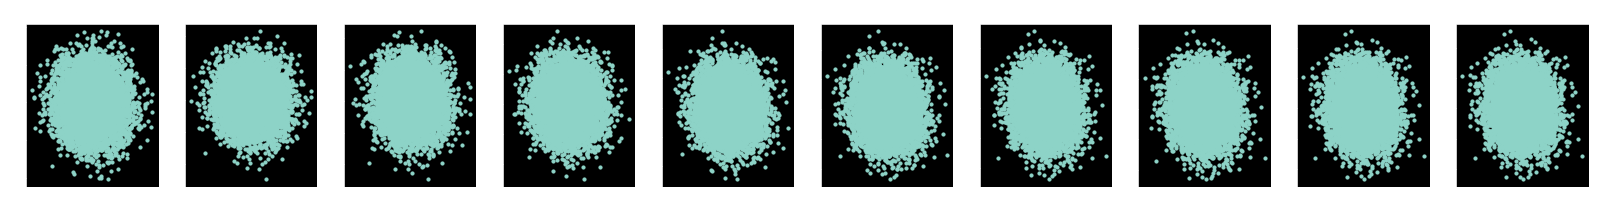

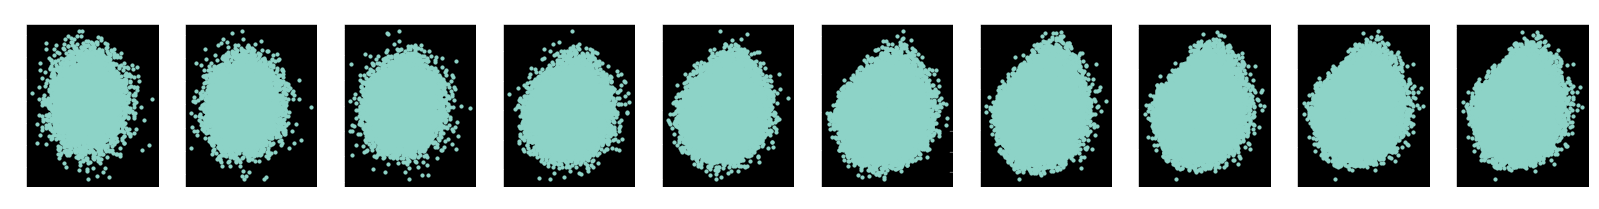

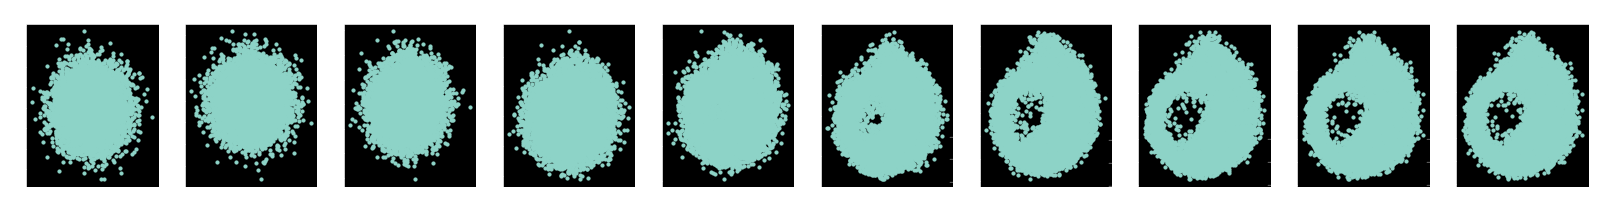

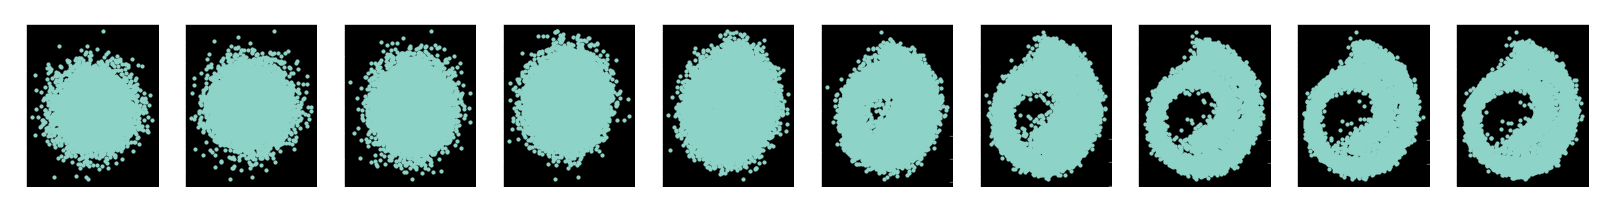

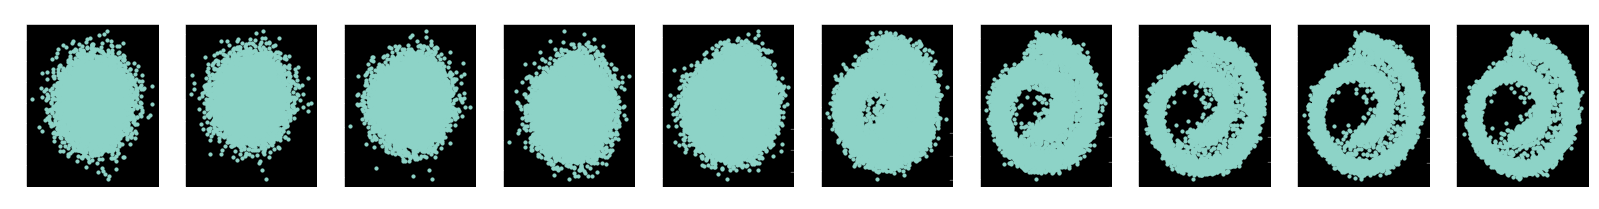

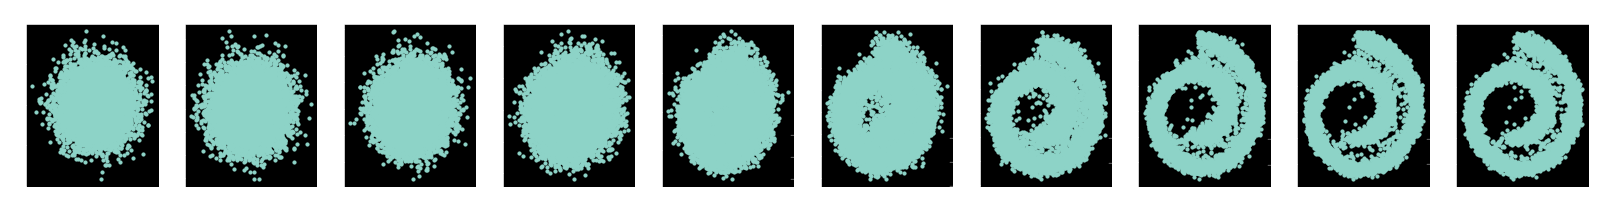

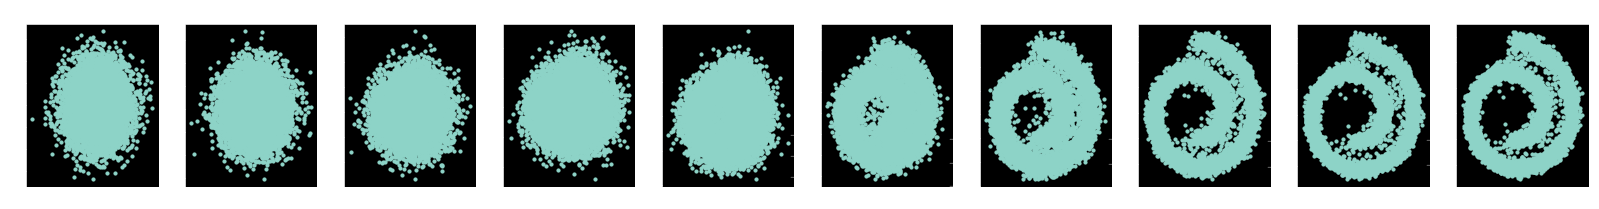

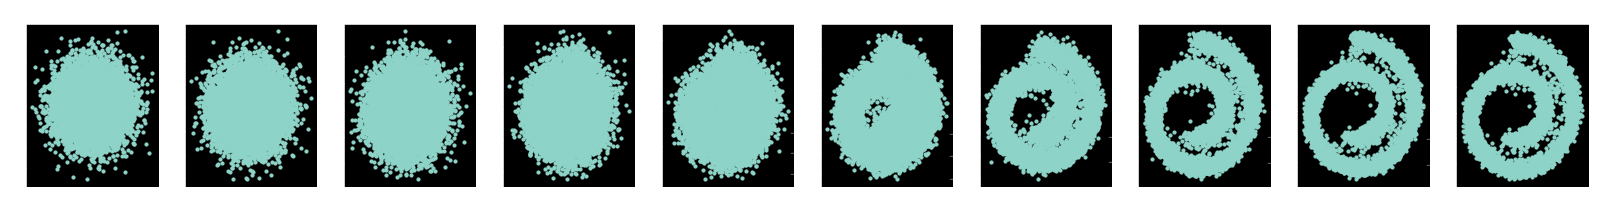

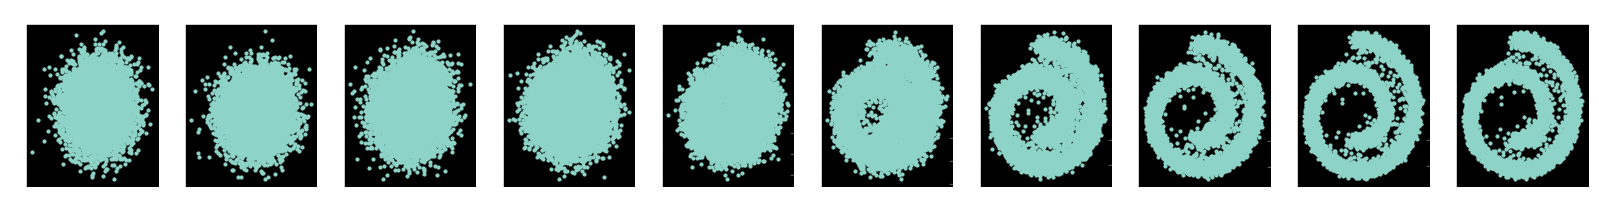

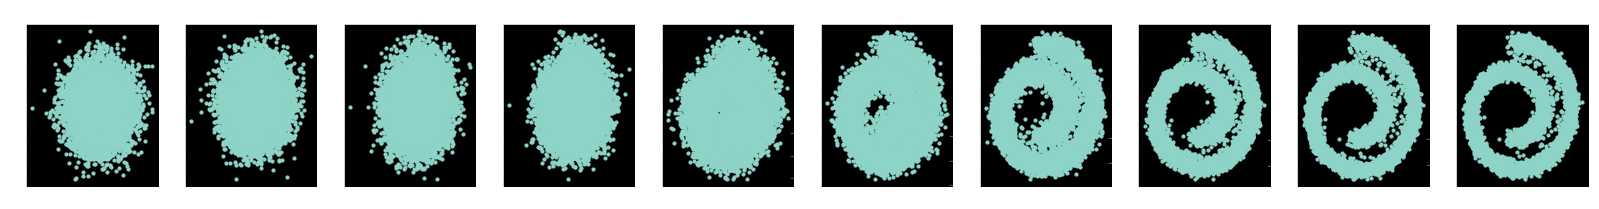

In [24]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## Bibliography

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)

<a id="ref3"/>

[3] [Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

<a id="ref4"/>

[4] [Song, J., Meng, C., & Ermon, S. (2020). Denoising Diffusion Implicit Models. arXiv preprint arXiv:2010.02502.](https://arxiv.org/pdf/2010.02502.pdf)

<a id="ref5"/>

[5] [Chen, N., Zhang, Y., Zen, H., Weiss, R. J., Norouzi, M., & Chan, W. (2020). _WaveGrad: Estimating gradients for waveform generation_. arXiv preprint arXiv:2009.00713.](https://arxiv.org/pdf/2009.00713)

<a id="ref6"/>

[6] [Hyvärinen, A. (2005). Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research, 6(Apr), 695-709.](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)

<a id="ref7"/>

[7] [Song, Y., Garg, S., Shi, J., & Ermon, S. (2020, August). Sliced score matching: A scalable approach to density and score estimation. In Uncertainty in Artificial Intelligence (pp. 574-584). PMLR.](https://arxiv.org/pdf/1905.07088.pdf)

<a id="ref8"/>

[8] [Song, Y., & Ermon, S. (2019). Generative modeling by estimating gradients of the data distribution. In Advances in Neural Information Processing Systems (pp. 11918-11930).](https://arxiv.org/pdf/1907.05600.pdf)

### Inspiration and sources

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb
https://github.com/ermongroup/sliced_score_matching